In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
import warnings
warnings.filterwarnings('ignore')

import json

import math

import tensorflow as tf
from tensorflow.keras import layers as k
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
image_size = (299, 299, 3)
batch_num = 128
epoch_num = 30

# create_model_name
model = 'InceptionV3_generator'
numbering = '03_2'
preprocessing_method ='only_sq'
class_type = 'remove_class1'
runtime_type = 'tpu'

# 고정 내역
max_pic_cnt = 1000
top_layer = 'customized_top_layer'

if runtime_type == 'tpu':
    model_name = f'{model}_{numbering}_{preprocessing_method}_{class_type}_batch({batch_num})_epoch({epoch_num})_tpu'
else :
    model_name = f'{model}_{numbering}_{preprocessing_method}_{class_type}_batch({batch_num})_epoch({epoch_num})'
print(model_name)

InceptionV3_generator_03_2_only_sq_remove_class1_batch(128)_epoch(30)_tpu


In [ ]:
# create model folder
base_path = f'/content/drive/MyDrive/project3/image_model/{model}'
if not os.path.exists(base_path):
    os.makedirs(base_path)

model_path = f'/content/drive/MyDrive/project3/image_model/{model}/{model_name}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

# result folder
result_path = f'/content/drive/MyDrive/project3/image_model/{model}/{model_name}/result'
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/project3/data/traindata/read_image.pkl')
df.head()

,file_path,type,middle_class,small_class,food_class,group_number,crop_area
0,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,1,NaN
1,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,2,NaN
2,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,3,NaN
3,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,4,NaN
4,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,5,NaN


In [ ]:
df.shape

(150283, 7)

In [ ]:
remove_class1_list = '/content/drive/MyDrive/project3/image_model/check_matrix/remove_class1.txt'

with open(remove_class1_list, 'r', encoding='utf-8') as file:
    remove_class1 = [line.strip() for line in file]

In [ ]:
print(len(remove_class1))

114


In [ ]:
# 남아 있는 클래스만 대상으로
df = df[df['food_class'].isin(remove_class1)]
df.shape

(113914, 7)

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['small_class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['small_class'])

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((91131, 7), (11391, 7), (11392, 7))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2

def process_image(image_array, new_ratio=1.5, new_image_size=299):
    height, width, _ = image_array.shape

    if width == height:
        new_image = cv2.resize(image_array, (new_image_size, new_image_size), interpolation=cv2.INTER_LINEAR)
        return new_image

    ratio = width / height if width > height else height / width

    if ratio > new_ratio:
        return None

    if width > height:
        new_width = int(height)
        left = (width - new_width) / 2
        right = (width + new_width) / 2
        top = 0
        bottom = height
    else:
        new_height = int(width)
        left = 0
        right = width
        top = (height - new_height) / 2
        bottom = (height + new_height) / 2

    cropped_image = image_array[int(top):int(bottom), int(left):int(right)]

    new_size = max(cropped_image.shape[:2])

    black_background = np.full((new_size, new_size, 3), 0, dtype=np.uint8)
    black_y_offset = (new_size - cropped_image.shape[0]) // 2
    black_x_offset = (new_size - cropped_image.shape[1]) // 2

    black_background[black_y_offset:black_y_offset+cropped_image.shape[0],
                     black_x_offset:black_x_offset+cropped_image.shape[1]] = cropped_image

    new_image = cv2.resize(black_background, (new_image_size, new_image_size), interpolation=cv2.INTER_LINEAR)
    new_image = new_image.astype(np.uint8)

    return new_image

class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, target_size=(299, 299), *args, **kwargs):
        generator = super().flow_from_directory(directory, target_size=target_size, *args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            new_batch_x = []
            new_batch_y = []
            for i in range(len(batch_x)):
                img = load_img(generator.filepaths[generator.index_array[i]])
                img_array = img_to_array(img)
                processed_img = process_image(img_array, new_image_size=target_size[0])
                if processed_img is not None:
                    new_batch_x.append(processed_img)
                    new_batch_y.append(batch_y[i])
            if new_batch_x:
                yield np.array(new_batch_x), np.array(new_batch_y)

# 데이터 생성기 설정


In [ ]:
## non_proprocessing
# train_datagen = ImageDataGenerator(rescale=1./255)

# only flip
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     horizontal_flip=True  # 수평 플립만 적용
# )


# ## only_gen
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# only_sq
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
)

## sq + gen
# train_datagen = CustomImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
new_image_size = (299, 299)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='small_class',
    target_size=new_image_size,
    batch_size=batch_num,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='small_class',
    target_size=new_image_size,
    batch_size=batch_num,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='small_class',
    target_size=new_image_size,
    batch_size=batch_num,
    class_mode='categorical',
    shuffle=False
)

Found 91131 validated image filenames belonging to 114 classes.
Found 11391 validated image filenames belonging to 114 classes.
Found 11392 validated image filenames belonging to 114 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Number of classes: 114


In [ ]:
# Load the InceptionV3
# model pre-trained -> by imagenet dataset
# without the top layer -> 마지막 결과를 내는 레이어 층에 관한
inception = InceptionV3(weights='imagenet', input_shape=[299, 299, 3], include_top=False)
inception.trainable = False  # Freeze the layers of InceptionV3

# Define the Customized top layer
model = tf.keras.models.Sequential([
    inception,
    k.GlobalAveragePooling2D(),
    k.Dropout(0.2),
    k.Dense(512, activation='relu'),
    k.BatchNormalization(),
    k.Dropout(0.1),
    k.Dense(256, activation='relu'),
    k.BatchNormalization(),
    k.Dropout(0.1),
    k.Dense(num_classes, activation='softmax')
])

print(model.summary())



87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_94 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                         

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, f'{model_name}_best.h5'),
                                   monitor='val_loss', save_best_only=True)



model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history = model.fit_generator(train_generator,
                              epochs=epoch_num,
                              steps_per_epoch= len(train_generator),
                              validation_data = val_generator,
                              validation_steps= len(val_generator),
                              use_multiprocessing=True,
                              callbacks=[model_checkpoint, early_stopping]
                              )

Epoch 1/30
712/712 [==============================] - 22525s 32s/step - loss: 1.8157 - categorical_accuracy: 0.5147 - precision: 0.7687 - recall: 0.3359 - val_loss: 1.3337 - val_categorical_accuracy: 0.6203 - val_precision: 0.7861 - val_recall: 0.4873
Epoch 2/30
712/712 [==============================] - 1721s 2s/step - loss: 1.3419 - categorical_accuracy: 0.6173 - precision: 0.7850 - recall: 0.4866 - val_loss: 1.2240 - val_categorical_accuracy: 0.6491 - val_precision: 0.8004 - val_recall: 0.5351
Epoch 3/30
712/712 [==============================] - 1779s 2s/step - loss: 1.2444 - categorical_accuracy: 0.6392 - precision: 0.7927 - recall: 0.5194 - val_loss: 1.1620 - val_categorical_accuracy: 0.6636 - val_precision: 0.7997 - val_recall: 0.5523
Epoch 4/30
712/712 [==============================] - 1829s 3s/step - loss: 1.1831 - categorical_accuracy: 0.6569 - precision: 0.8022 - recall: 0.5432 - val_loss: 1.1141 - val_categorical_accuracy: 0.6819 - val_precision: 0.8153 - val_recall: 0.573

In [18]:
# model save
model.save(os.path.join(model_path, f'{model_name}.h5'))


# training history save
with open(os.path.join(result_path, f'{model_name}_history.json'), 'w') as f:
    json.dump(history.history, f)

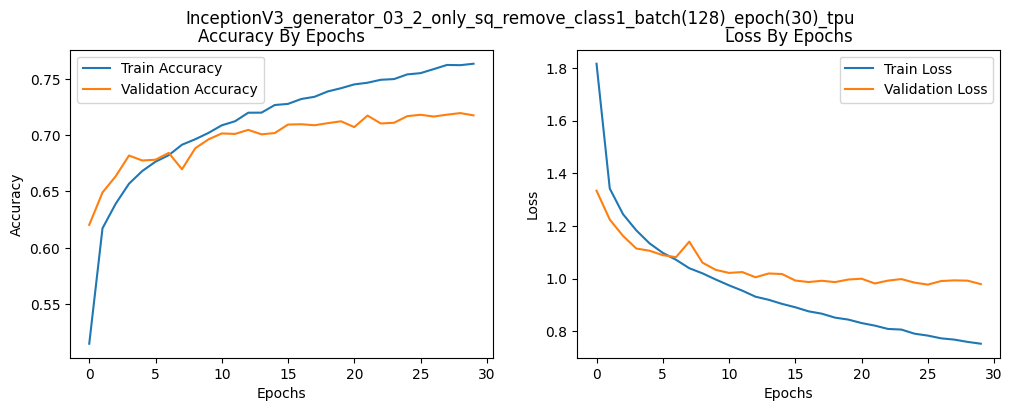

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy By Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss By Epochs')

plt.suptitle(f'{model_name}')

# save training_plot
plt.savefig(os.path.join(result_path, f'{model_name}_training_plot.png'))
plt.show()

89/89 [==============================] - 2417s 27s/step
                      precision    recall  f1-score   support

          가지볶음       0.53      0.70      0.60       100
         간장게장       0.75      0.82      0.78       100
            갈비찜       0.71      0.55      0.62       100
          감자조림       0.65      0.83      0.73       100
       감자채볶음       0.80      0.92      0.86       100
            감자탕       0.65      0.47      0.55       100
            갓김치       0.74      0.55      0.63        99
       건새우볶음       0.76      0.73      0.74       100
            계란국       0.59      0.63      0.61       100
          계란말이       0.80      0.73      0.76       100
            계란찜       0.76      0.87      0.81       100
         계란후라이       0.77      0.83      0.80       100
         고등어구이       0.61      0.73      0.67       100
         고사리나물       0.77      0.88      0.82       100
고추장진미ᄎ

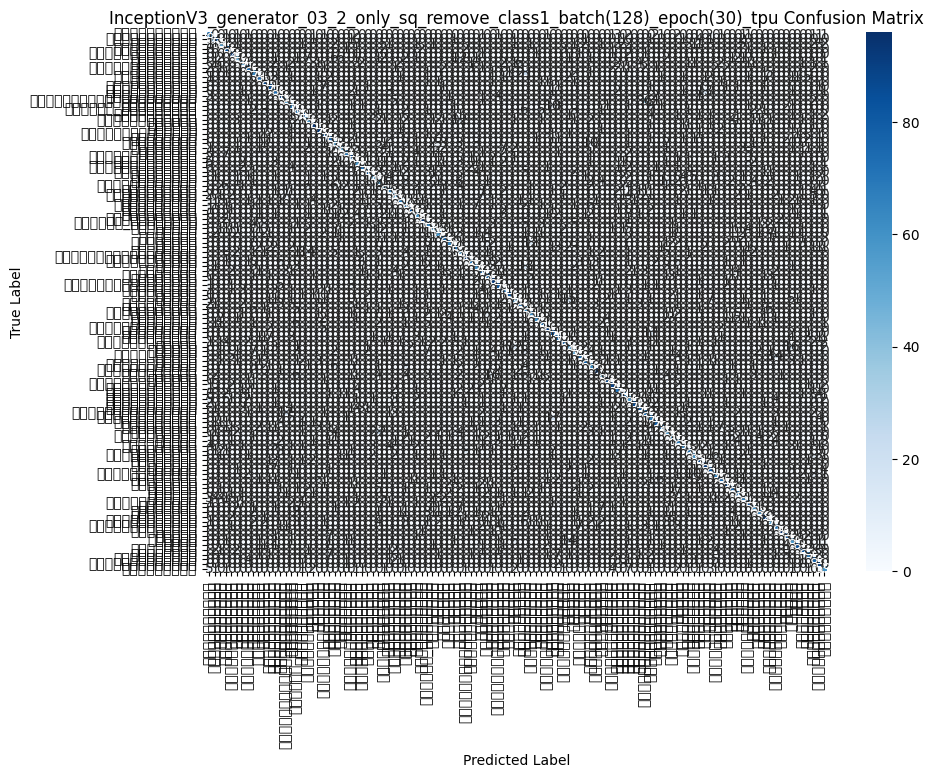

In [20]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print classification report for detailed metrics
class_report = classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys())
print(class_report)

with open(os.path.join(result_path, f'{model_name}_classification_report.txt'), 'w') as f:
    f.write(class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')

plt.savefig(os.path.join(result_path, f'{model_name}_confusion_matrix.png'))
plt.show()

In [21]:

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print('Accuracy:', accuracy)

# Calculate precision and recall using sklearn
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print('Precision:', precision)
print('Recall:', recall)

# Append accuracy to a text file
with open(os.path.join(base_path, 'accuracy.txt'), 'a') as f:
    f.write(f'{model_name}_Accuracy: {accuracy:.2f}%\n')
    f.write(f'{model_name}_Precision: {precision:.2f}%\n')
    f.write(f'{model_name}_Recall: {recall:.2f}%\n')

Accuracy: 0.7105863764044944
Precision: 0.7192653597162036
Recall: 0.7105863764044944


In [22]:
val_prediction = model.predict_generator(val_generator, steps = len(val_generator))

In [23]:
food_classes = val_generator.class_indices
print(food_classes)

{'가지볶음': 0, '간장게장': 1, '갈비찜': 2, '감자조림': 3, '감자채볶음': 4, '감자탕': 5, '갓김치': 6, '건새우볶음': 7, '계란국': 8, '계란말이': 9, '계란찜': 10, '계란후라이': 11, '고등어구이': 12, '고사리나물': 13, '고추장진미채볶음': 14, '고추튀김': 15, '곰탕_설렁탕': 16, '곱창구이': 17, '곱창전골': 18, '과메기': 19, '김밥': 20, '김치볶음밥': 21, '김치전': 22, '김치찌개': 23, '김치찜': 24, '깍두기': 25, '깻잎장아찌': 26, '꽁치조림': 27, '꽈리고추무침': 28, '나박김치': 29, '닭갈비': 30, '닭계장': 31, '닭볶음탕': 32, '더덕구이': 33, '도라지무침': 34, '도토리묵': 35, '된장찌개': 36, '두부김치': 37, '두부조림': 38, '땅콩조림': 39, '떡국_만두국': 40, '떡볶이': 41, '라면': 42, '라볶이': 43, '막국수': 44, '만두': 45, '매운탕': 46, '메추리알장조림': 47, '멸치볶음': 48, '무국': 49, '무생채': 50, '물냉면': 51, '미역국': 52, '미역줄기볶음': 53, '배추김치': 54, '백김치': 55, '보쌈':

In [24]:
# y가 예측한 레이블
val_y_pred = np.argmax(val_prediction, axis = 1)
# 실제 y 값
val_y_true = val_generator.classes

print("val_y_pred ===  ", val_y_pred[:50])
print("val_y_true ===  ", val_y_true[:50])

val_y_pred ===   [ 38  27  58  55   9   8  98 101  70  65 100  50  12  67  20  94  73   8
  82 111  26  71  70  77  90  92  81  57  57 110  75  21  88  66  48  71
  58  21  75  47  82 105  39  22 106  91  49  56   3  97]
val_y_true ===   [36, 109, 69, 30, 56, 41, 11, 1, 55, 11, 108, 9, 113, 106, 47, 10, 65, 10, 96, 36, 27, 63, 34, 26, 13, 50, 14, 98, 93, 98, 44, 7, 3, 79, 15, 102, 1, 56, 62, 37, 12, 64, 93, 36, 108, 93, 30, 29, 26, 105]


In [25]:
# confusion_matrix
food_confusion_matrix = confusion_matrix(val_y_true, val_y_pred)
print(food_confusion_matrix)
print("shape==", food_confusion_matrix.shape)

[[1 2 3 ... 1 1 0]
 [1 2 1 ... 1 2 2]
 [1 1 2 ... 3 1 0]
 ...
 [3 0 1 ... 0 1 0]
 [2 0 1 ... 1 3 1]
 [3 1 0 ... 0 1 0]]
shape== (114, 114)


<Axes: title={'center': 'confusion_matrix (x : Predicted, y : Actual) '}>

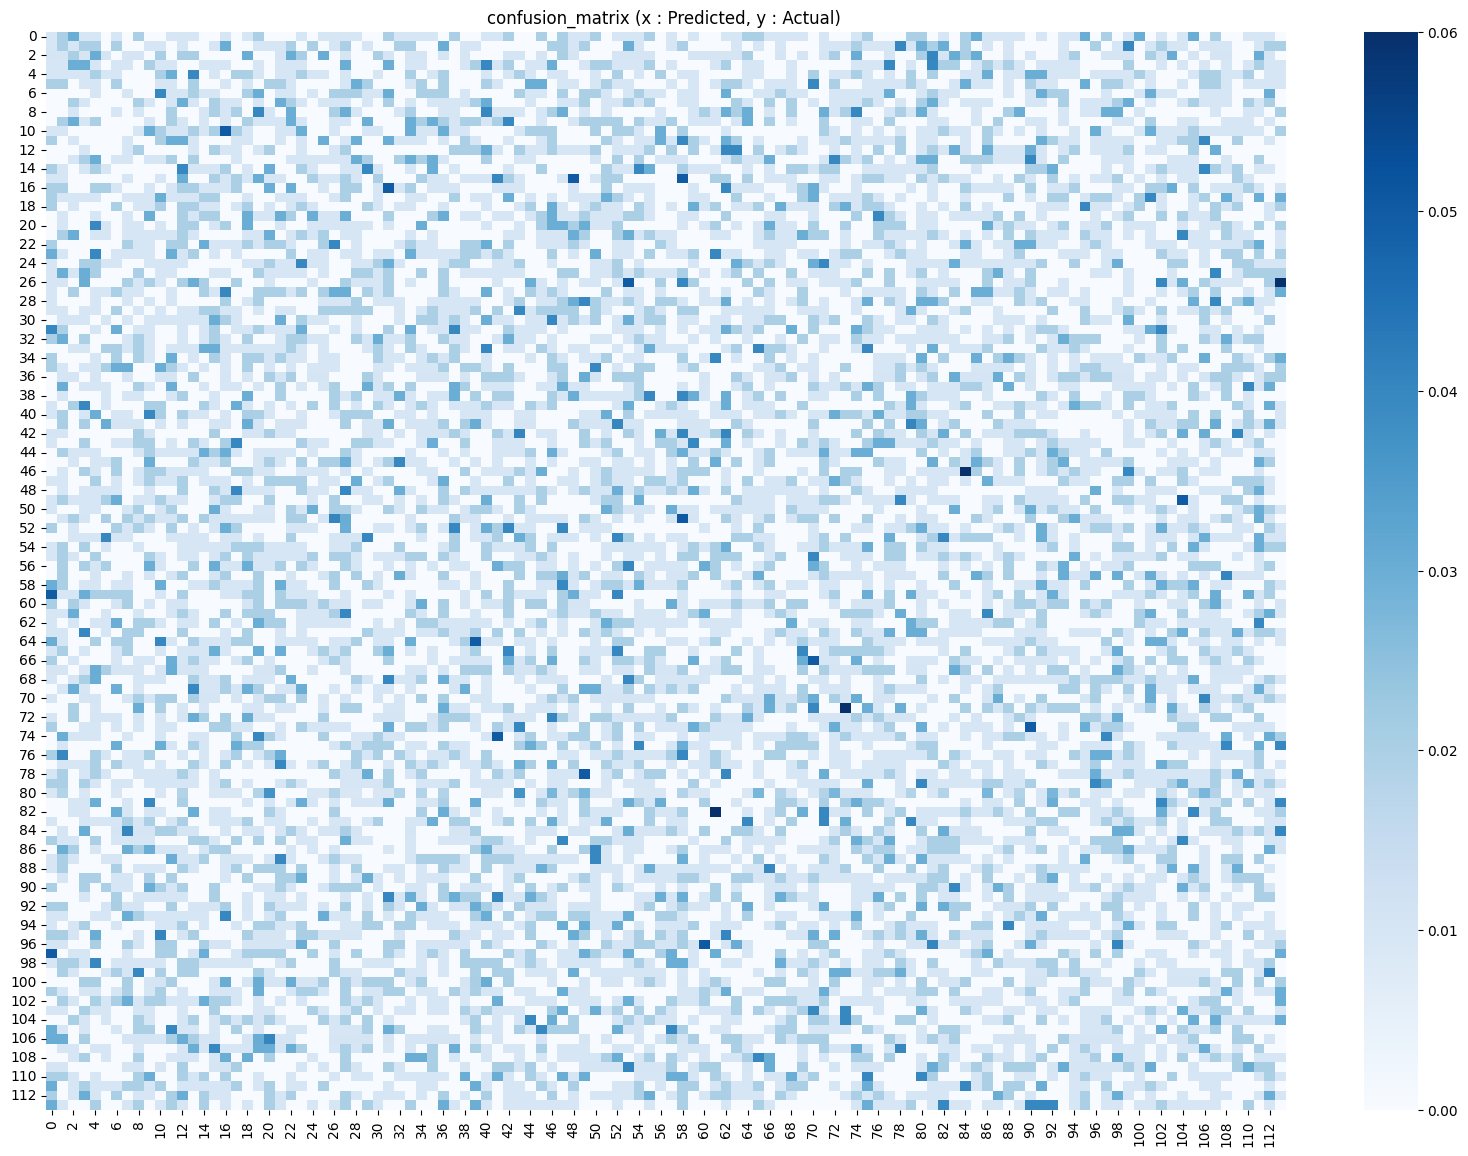

In [26]:
import seaborn as sns
import pandas as pd

# 단순히 갯수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보일 수 있다.
# 현재 validation set의 class별 이미지 갯수는 전처리 과정에서 일부 누락된 게 있어 모두 100개가 아님
# --> 비율로 confusion_matrix를 normalize한다!

row_sums = food_confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = food_confusion_matrix / row_sums

df_cm = pd.DataFrame(norm_conf_mx, index = range(num_classes),columns=range(num_classes))

plt.figure(figsize = (20,14))
plt.title("confusion_matrix (x : Predicted, y : Actual) ")

sns.heatmap(df_cm, annot=False, cmap="Blues")

In [27]:
# 각 index별 음식 이름
food_classes = val_generator.class_indices
print(food_classes)

{'가지볶음': 0, '간장게장': 1, '갈비찜': 2, '감자조림': 3, '감자채볶음': 4, '감자탕': 5, '갓김치': 6, '건새우볶음': 7, '계란국': 8, '계란말이': 9, '계란찜': 10, '계란후라이': 11, '고등어구이': 12, '고사리나물': 13, '고추장진미채볶음': 14, '고추튀김': 15, '곰탕_설렁탕': 16, '곱창구이': 17, '곱창전골': 18, '과메기': 19, '김밥': 20, '김치볶음밥': 21, '김치전': 22, '김치찌개': 23, '김치찜': 24, '깍두기': 25, '깻잎장아찌': 26, '꽁치조림': 27, '꽈리고추무침': 28, '나박김치': 29, '닭갈비': 30, '닭계장': 31, '닭볶음탕': 32, '더덕구이': 33, '도라지무침': 34, '도토리묵': 35, '된장찌개': 36, '두부김치': 37, '두부조림': 38, '땅콩조림': 39, '떡국_만두국': 40, '떡볶이': 41, '라면': 42, '라볶이': 43, '막국수': 44, '만두': 45, '매운탕': 46, '메추리알장조림': 47, '멸치볶음': 48, '무국': 49, '무생채': 50, '물냉면': 51, '미역국': 52, '미역줄기볶음': 53, '배추김치': 54, '백김치': 55, '보쌈':

In [28]:
# food_dict -> key : 음식 이름, value : index인 dictionary
food_dict = val_generator.class_indices
# foods_prob : (음식 이름, 음식의 index, 예측값=실제값일 확률)인 tuple을 각 원소로 갖는 list
foods_prob = [(food_name,idx, prob) for food_name, idx, prob in zip(food_dict.keys(), food_dict.values() ,np.diag(norm_conf_mx))]
foods_prob =  sorted(foods_prob,key= lambda x : x[2])
print(foods_prob)

[('감자탕', 5, 0.0), ('갓김치', 6, 0.0), ('건새우볶음', 7, 0.0), ('고등어구이', 12, 0.0), ('곱창구이', 17, 0.0), ('김밥', 20, 0.0), ('김치볶음밥', 21, 0.0), ('김치찌개', 23, 0.0), ('깻잎장아찌', 26, 0.0), ('닭갈비', 30, 0.0), ('두부조림', 38, 0.0), ('떡볶이', 41, 0.0), ('만두', 45, 0.0), ('매운탕', 46, 0.0), ('무국', 49, 0.0), ('무생채', 50, 0.0), ('물냉면', 51, 0.0), ('미역국', 52, 0.0), ('백김치', 55, 0.0), ('비빔냉면', 59, 0.0), ('삼계탕', 61, 0.0), ('새우튀김', 63, 0.0), ('수육', 66, 0.0), ('수제비', 67, 0.0), ('숙주나물', 68, 0.0), ('시금치나물', 71, 0.0), ('오이소박이', 79, 0.0), ('오징어채볶음', 80, 0.0), ('오징어튀김', 81, 0.0), ('유부초밥', 83, 0.0), ('잡채', 86, 0.0), ('장어구이', 87, 0.0), ('장조림', 88, 0.0), ('주먹밥', 94, 0.0), ('쫄면', 97, 0.0), ('찜닭', 98, 0.0), ('총각김치', 99, 0.0), ('콩국수', 102, 0.0), ('콩나물국', 103, 0.0), ('콩나물무침', 104, 0.0), ('파전', 106, 0.0), ('호박전', 110, 

In [29]:
# 잘 분류될 확률이 60% 이하인 음식들
bad_classfifed_foods = [food_prob for food_prob in foods_prob if food_prob[2] <= 0.6 ]
bad_classfifed_foods

[('감자탕', 5, 0.0),
 ('갓김치', 6, 0.0),
 ('건새우볶음', 7, 0.0),
 ('고등어구이', 12, 0.0),
 ('곱창구이', 17, 0.0),
 ('김밥', 20, 0.0),
 ('김치볶음밥', 21, 0.0),
 ('김치찌개', 23, 0.0),
 ('깻잎장아찌', 26, 0.0),
 ('닭갈비', 30, 0.0),
 ('두부조림', 38, 0.0),
 ('떡볶이', 41, 0.0),
 ('만두', 45, 0.0),
 ('매운탕', 46, 0.0),
 ('무국', 49, 0.0),
 ('무생채', 50, 0.0),
 ('물냉면', 51, 0.0),
 ('미역국', 52, 0.0),
 ('백김치', 55, 0.0),
 ('비빔냉면', 59, 0.0),
 ('삼계탕', 61, 0.0),
 ('새우튀김', 63, 0.0),
 ('수육', 66, 0.0),
 ('수제비', 67, 0.0),
 ('숙주나물', 68, 0.0),
 ('시금치나물', 71, 0.0),
 ('오이소박이', 79, 0.0),
 ('오징어채볶음', 80, 0.0),
 ('오징어튀김', 81, 0.0),
 ('유부초밥', 83, 0.0),
 ('잡채', 86, 0.0),
 ('장어구이', 87, 0.0),
 ('장조림', 88, 0.0),
 ('주먹밥', 94, 0.0),
 ('쫄면', 97, 0.0),
 ('찜닭', 98, 0.0),
 ('총각김치', 99, 0.0),
 ('콩국수', 102, 0.0),
 ('콩나물국', 103, 0.0),
 ('콩나물무침', 104, 0.0),
